In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Acessando pasta com dataset
%cd "/content/drive/MyDrive/atlantico_academy/dataset_total/dados_alterados"
!ls

/content/drive/MyDrive/atlantico_academy/dataset_total/dados_alterados
cloudy	rain  shine  sunrise


In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install matplotlib==3.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Classificação de imagens de tempo

**Classificação de Imagens**

> Classificação de imagens de tempo utilizando técnicas clássicas de Processamento Digital de Imagens e treinar classificadores para predição dos atributos.

In [ ]:
### Módulos necessários
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils
import seaborn as sns
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics,svm
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from sklearn.preprocessing import MaxAbsScaler
from google.colab.patches import cv2_imshow
from skimage import io, img_as_ubyte
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import random



- **Preparando o dataset**

> Neste primeiro momento há necessidade de observar as imagens do dataset e organizá-las em uma estrutura de dados adequada para que seus atributos possam ser extraídos. há então a necessidade de carregar o conjunto de imagens via código.

In [ ]:
def load_data(datadir, classes, img_size=100):
    training_data = []
    label = []
    extras = []
    for classe in range(len(classes)):
        path = os.path.join(datadir, classes[classe])
        shufled_list  = list(os.listdir(path))
        shuffle(shufled_list)
        for i, img in enumerate(shufled_list):
            if '(' not in img:
              img_array = cv2.imread(os.path.join(path, img))
              img_array = cv2.resize(img_array, (img_size, img_size))
            #if i == 213:
            #  break  
            #extras.append(img)
            
           # if classe == 3:
            #  extras.append(img)
            #  break
            '''
            Tinha um gif na rain141 e um desconhecido na shine131
            try:
              img_array = cv2.resize(img_array, (img_size, img_size))
            except:
              print(img)
              print(path)
              print(i, classe)
              print(img_array)
              pass
            '''
            #img_array = cv2.resize(img_array, (img_size, img_size)).flatten()
            
            training_data.append(img_array)
            label.append(classe)
            
    return training_data, label

In [ ]:
data, label= load_data('./', ['cloudy','rain','shine','sunrise'])

In [ ]:
qtd_0 = label.count(0)
qtd_1 = label.count(1)
qtd_2 = label.count(2)
qtd_3 = label.count(3) 

In [ ]:
print(label.count(0), label.count(1), label.count(2), label.count(3))

213 213 213 213


In [ ]:
dados_cloudy = data[0:qtd_0]
dados_rain = data[qtd_0:qtd_1+qtd_0]
dados_shine = data[qtd_1+qtd_0:qtd_2+qtd_1+qtd_0]
dados_sunrise = data[qtd_2+qtd_1+qtd_0:qtd_3+qtd_2+qtd_1+qtd_0]

In [ ]:
# Funcoes para geracao de imagens
def rotacao_anti(image):
  '''
  Função responsável por fazer a rotação anti-horaria da imagem.
  Entrada: Imagem
  Saída: Imagem rotacionada entre 0 a 180° no sentindo anti-horario
  '''
  angle = 2
  return imutils.rotate(image, angle)

def rotacao_horaria(image):
  '''
  Função responsável por fazer a rotação horaria da imagem.
  Entrada: Imagem
  Saída: Imagem rotacionada entre 0 a 180° no sentindo horario
  '''
  angle = 2
  return imutils.rotate(image, -angle)

def h_flip(image):
  '''
  Função responsável por fazer a inversão horizontal da imagem.
  Entrada: Imagem
  Saída: Imagem invertida no sentido horizontal
  '''
  return np.fliplr(image)

In [ ]:
for i in range(57):
  if i%2==0:
    dados_cloudy.append(rotacao_anti(dados_cloudy[i]))
  else:
    dados_cloudy.append(rotacao_horaria(dados_cloudy[i]))
  label.append(0)
  label.sort()

for i in range(143):
  if i%2==0:
    dados_rain.append(rotacao_anti(dados_rain[i]))
  else:
    dados_rain.append(rotacao_horaria(dados_rain[i]))
  label.append(1)
  label.sort()

for i in range(105):
  if i%2==0:
    dados_shine.append(rotacao_anti(dados_shine[i]))
  else:
    dados_shine.append(rotacao_horaria(dados_shine[i]))
  label.append(2)
  label.sort()
# concatena as listas
data = dados_cloudy+dados_rain+dados_shine+dados_sunrise

In [ ]:
# quantidade por classe
print(label.count(0), label.count(1), label.count(2), label.count(3))

300 214 252 357


In [ ]:
# quantidade total de dados
len(data)

1428

- O código acima realiza a implementação de uma função que recebe 3 argumentos: o diretório que contem as pastas das imagens, uma lista de string que contém o nome das classes que devem ser reconhecidas e um parâmetro default que é o  tamanho da imagem que será utilizado em todo o processo. 


- São definidas duas listas vazias training_data e label. Em ***training_data*** serão armazenadas as imagens e em ***label*** serão definidos números que representam cada classe. Deste modo, é possível saber a classe da imagem que estiver na posição 5 da lista training_data observando o número contido da quinta posição da lista label.

- Um loop for é realizado para iterar sobre as possíveis classes. Assim a variável classe, definida no loop, poderá assumir valores variando de  0 até 3, em que 0 representa classe **'cloudy'** e 3 representa a classe **'sunrise'**. Na variável path é armazenada a string que contem o caminho para pasta de imagens da classe específica, conforme iteração do loop for e na estrutura shufled_list são contidas strings que são os caminhos de cada imagem da classe, já com um primeiro embaralhamento.

### Extração de atributos

> Definir dois métodos para obter uma imagem de entrada e convertê-la em um vetor de recursos ou uma lista de números que quantificam o conteúdo de uma imagem:




In [ ]:
def image_to_feature_vector(image, size=(32, 32)):
    return cv2.resize(image, size).flatten()

> A função aceita uma imagem de entrada e constrói um histograma de cores para caracterizar a distribuição de cores da imagem.



In [ ]:
##### Filtro de média
blur_data = []
for i in range(len(data)):
    blur_img = cv2.blur(data[i], ksize=(3,3))
    blur_data.append(blur_img)

##### GaussianBlur

gaussian_data = []
for i in range(len(data)):
    gaussian_img = cv2.GaussianBlur(src=data[i], ksize=(15,15),sigmaX=0)
    gaussian_data.append(gaussian_img)

#### Equalização do histograma

##### HSV

Eq_data = []
for i in range(len(data)):
    img = data[i]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    canais =  cv2.split(hsv)
    cv2.equalizeHist(canais[2],canais[2])
    cv2.merge(canais, hsv)
    Eq_data.append(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))

#### Filtro    Máscara de Desaguçamento

# Filtro máscara de desaguçamento, ou    filtro    de realce

realce_data = []
for i in range(len(data)):
    imgOriginal = data[i]
    imgSuavizada = cv2.GaussianBlur(imgOriginal, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(imgOriginal, imgSuavizada)
    imgRealcada = cv2.add(imgOriginal, imgDetalhes)
    realce_data.append(imgRealcada)

In [ ]:
from skimage import exposure
def extract_color_histogram(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    # realizar a equalização do histograma
    image_eq = exposure.equalize_hist(imgRealcada)
    # determinar a media do valor dos pixels que ocorrem na imagem  equalizada
    img_mean_eq = np.mean(image_eq)*255
    return img_mean_eq.flatten()

def extract_color_histogram2(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    #hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)
    
    hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)
    #hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [0, 180, 0, 256, 0, 256])
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [ 0 , 256 , 0 , 256 , 0 , 256 ])
    hist_norm = cv2.normalize(hist, hist)
    
    return hist_norm.flatten()


def extract_color_histogram_apenas_para_V(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    #hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)
    
    hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)
    #hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [0, 180, 0, 256, 0, 256])
    #hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [ 0 , 256 , 0 , 256 , 0 , 256 ])
    hist = cv2.calcHist([hsv], [2], None, [8], [0 , 256 ])
    hist_norm = cv2.normalize(hist, hist)
    
    return hist_norm.flatten()

def extrair_apenas_no_hsv(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [2], None, [8], [0 , 256 ])
    hist_norm = cv2.normalize(hist, hist)
    return hist_norm.flatten()

def extrair_suavizacao_gaussian(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    hist = cv2.calcHist([imgSuavizada], [0, 1, 2], None, (8, 8, 8), [ 0 , 256 , 0 , 256 , 0 , 256 ])
    hist_norm = cv2.normalize(hist, hist)
    return hist_norm.flatten()

def mediana_13_13(image):
  imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
  return imgSuavizada.flatten()

def desagucameno(image):
  imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
  imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
  imgRealcada = cv2.add(image, imgDetalhes)
  return imgRealcada.flatten()


def lbp(image):
  def get_pixel(img, center, x, y):
      
    new_value = 0
      
    try:
        # If local neighbourhood pixel 
        # value is greater than or equal
        # to center pixel values then 
        # set it to 1
        if img[x][y] >= center:
            new_value = 1
              
    except:
        # Exception is required when 
        # neighbourhood value of a center
        # pixel value is null i.e. values
        # present at boundaries.
        pass
      
    return new_value
    
  # Function for calculating LBP
  def lbp_calculated_pixel(img, x, y):
    
      center = img[x][y]
    
      val_ar = []
        
      # top_left
      val_ar.append(get_pixel(img, center, x-1, y-1))
        
      # top
      val_ar.append(get_pixel(img, center, x-1, y))
        
      # top_right
      val_ar.append(get_pixel(img, center, x-1, y + 1))
        
      # right
      val_ar.append(get_pixel(img, center, x, y + 1))
        
      # bottom_right
      val_ar.append(get_pixel(img, center, x + 1, y + 1))
        
      # bottom
      val_ar.append(get_pixel(img, center, x + 1, y))
        
      # bottom_left
      val_ar.append(get_pixel(img, center, x + 1, y-1))
        
      # left
      val_ar.append(get_pixel(img, center, x, y-1))
        
      # Now, we need to convert binary
      # values to decimal
      power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    
      val = 0
        
      for i in range(len(val_ar)):
          val += val_ar[i] * power_val[i]
            
      return val
    
  #path = 'GFG.png'
  #img_bgr = cv2.imread(path, 1)
  img_bgr = image
  height, width, _ = img_bgr.shape
    
  # We need to convert RGB image 
  # into gray one because gray 
  # image has one channel only.
  img_gray = cv2.cvtColor(img_bgr,
                          cv2.COLOR_BGR2GRAY)
    
  # Create a numpy array as 
  # the same height and width 
  # of RGB image
  img_lbp = np.zeros((height, width),
                    np.uint8)
    
  for i in range(0, height):
      for j in range(0, width):
          img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
  hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
  hist_norm = cv2.normalize(hist_lbp, hist_lbp)
  return hist_norm.flatten()

def media_cor_canais(image):
  imgRGB = image
  valorMedioRGB = cv2.mean(imgRGB)
  valorMedioRgb = np.asarray(valorMedioRGB)
  return valorMedioRgb[0:3].flatten()


In [ ]:
features_ = []
features_1 = []
features_2 = []
features_3 = []
def features_extraction(images):
    features_list = []
    for image in images:
        #print(image.shape)
        hist= extract_color_histogram2(image)
        
        #image_lbp = lbp(image)
        #image_color = media_cor_canais(image)
        #hist = extract_color_histogram2(image)
        features_list.append(hist)
    return features_list

features = features_extraction(data)

In [ ]:
features_ = []
features_1 = []
features_2 = []
features_3 = []
features_4 = []
def features_extraction_novo(images):
    features_list = []
    features_hsv = []
    features_gaussiana = []
    features_3 = []
    features_4 = []
    for image in images:
        apenas_hsv = extrair_apenas_no_hsv(image)
        suavizacao_gaussiana = extrair_suavizacao_gaussian(image)
    
        features_hsv.append(apenas_hsv)
        features_gaussiana.append(suavizacao_gaussiana)
    return features_hsv, features_gaussiana

features_1, features_2 = features_extraction_novo(data)

In [ ]:
features_1 = []
features_2 = []
features_3 = []
for vetor in features:
  for k, j in enumerate(vetor): 
    if k == 0:
      features_1.append(j)
    elif k == 1:
       features_2.append(j)
    else:
      features_3.append(j)

In [ ]:
len(features)

1123

In [ ]:
features[0]

array([155.0464, 150.0425, 148.0188])

- **Treinamento e Teste dos Classificadores.**
> A variável features possui as os atributos extraídos das imagens. Neste contexto, a função gen_classifiers é iamplementada para retornar testes em 7 classificadores: Random Forest, MLP, KNN, SGDC, SVM, Árvore de decisão e Naive Bayes.

In [ ]:
def generate_svm_model(train_data,label_train_data,test_data):
    clf = svm.SVC(kernel='linear')
    clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_SGDC_model(train_data,label_train_data,test_data):
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)
    clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_naive_bayes_model(train_data,label_train_data,test_data):
    gnb = GaussianNB()
    gnb.fit(train_data, label_train_data)
    predicted = gnb.predict(test_data)
    return predicted
def generate_decision_tree_model(train_data,label_train_data,test_data):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_random_forest_model(X_train, y_train,test_data):
    rfc = RandomForestClassifier(criterion= 'entropy', max_depth= 8, max_features='auto', n_estimators=200)
    rfc.fit(X_train,y_train)
    predicted = rfc.predict(test_data)
    return predicted
def generate_MLP_model(X_train, y_train,test_data):
    classifier = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(test_data)
    return predicted
def generate_knn_model(train_data,label_train_data,test_data):
    knn = KNeighborsClassifier()
    knn.fit(train_data,label_train_data)
    predicted = knn.predict(test_data)
    return predicted


In [ ]:
def gen_classifiers(train_data,label_train_data,test_data):
    return generate_knn_model(train_data,label_train_data,test_data),\
    generate_MLP_model(train_data,label_train_data,test_data),\
    generate_SGDC_model(train_data,label_train_data,test_data),\
    generate_svm_model(train_data,label_train_data,test_data),\
    generate_decision_tree_model(train_data,label_train_data,test_data),\
    generate_naive_bayes_model(train_data,label_train_data,test_data),\
    generate_random_forest_model(train_data,label_train_data,test_data),

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.3)
results = gen_classifiers(X_train, y_train,X_test)

- A função divide o conjunto de atributos e labels em conjuntos de treino e teste para garantirmos que o processo de treinamento seja realizado com dados distintos dos que vão ser testados por cada classificador.

- Deste modo, a função gen_classifiers recebe os atributos de treinamento, as labels dos atributos de treinamento e os atribiutos de teste e retorna um array de valores que indicam os resultados dos testes de cada classificador. Cada classificador é inicializado com um objeto específico. Após a inicialização é realizado o comando fit para treinar o classificadorque recebe os atribiutos de treinamento e as labels dos atributos. Após o treinamento é realizado o comando predict para testar se o classificador realiza uma predição correta de atributos que não foram utilizados no conjunto de treinamento. A variável predicted é um vetor em que cada elemento do vetor é um valor que indica a classe a qual o atributo pertence. 

- **Avaliação dos classificadores**
> A biblioteca sklearn possui funções que auxiliam a medir quantitativamente o desempenho do classificador. A acurácia do classificador pode ser medida pela chamada da função seguinte:

In [ ]:
acc_knn = metrics.accuracy_score(y_test, results[0])
acc_MLP = metrics.accuracy_score(y_test, results[1])
acc_SGDC = metrics.accuracy_score(y_test, results[2])
acc_svm = metrics.accuracy_score(y_test, results[3])
acc_decision_tree = metrics.accuracy_score(y_test, results[4])
acc_naive_bayes = metrics.accuracy_score(y_test, results[5])
acc_random_forest = metrics.accuracy_score(y_test, results[6])

print("Acc KNN: {:.3f}".format(acc_knn))
print("Acc MLP: {:.3f}".format(acc_MLP))
print("Acc SGDC: {:.3f}".format(acc_SGDC))
print("Acc svm: {:.3f}".format(acc_svm))
print("Acc decision_tree: {:.3f}".format(acc_decision_tree))
print("Acc naive_bayes: {:.3f}".format(acc_naive_bayes))
print("Acc random_forest: {:.3f}".format(acc_random_forest))

Acc KNN: 0.825
Acc MLP: 0.861
Acc SGDC: 0.834
Acc svm: 0.840
Acc decision_tree: 0.819
Acc naive_bayes: 0.792
Acc random_forest: 0.866


In [ ]:
acc_knn = metrics.accuracy_score(y_test, results[0])
acc_MLP = metrics.accuracy_score(y_test, results[1])
acc_SGDC = metrics.accuracy_score(y_test, results[2])
acc_svm = metrics.accuracy_score(y_test, results[3])
acc_decision_tree = metrics.accuracy_score(y_test, results[4])
acc_naive_bayes = metrics.accuracy_score(y_test, results[5])
acc_random_forest = metrics.accuracy_score(y_test, results[6])

print("Acc KNN: {}".format(acc_knn))
print("Acc MLP: {}".format(acc_MLP))
print("Acc SGDC: {}".format(acc_SGDC))
print("Acc svm: {}".format(acc_svm))
print("Acc decision_tree: {}".format(acc_decision_tree))
print("Acc naive_bayes: {}".format(acc_naive_bayes))
print("Acc random_forest: {}".format(acc_random_forest))

Acc KNN: 0.8249258160237388
Acc MLP: 0.8605341246290801
Acc SGDC: 0.8338278931750742
Acc svm: 0.8397626112759644
Acc decision_tree: 0.8189910979228486
Acc naive_bayes: 0.7922848664688428
Acc random_forest: 0.8664688427299704


In [ ]:
modelos_list_acc= np.array([acc_knn, acc_MLP, acc_SGDC, acc_svm, acc_decision_tree, acc_naive_bayes, acc_random_forest])
modelos_list_acc = modelos_list_acc*100
modelos_list_precision = np.array([precision(y_test, results[i]) for i in range(6)])
modelos_list_recall= np.array([recall(y_test, results[i]) for i in range(6)])
modelos_list_f1 = np.array([f1_score(y_test, results[i]) for i in range(6)])
titulos_list=["KNN", "MLP", "SGDC", "SVM", "DT", "NB", "RF"]
histograma=pd.DataFrame(list(zip(titulos_list,modelos_list_acc)), columns = ['Modelos','ACC'])

In [ ]:
histograma

,Modelos,ACC
0,KNN,82.492582
1,MLP,86.053412
2,SGDC,83.382789
3,SVM,83.976261
4,DT,81.899110
5,NB,79.228487
6,RF,86.646884


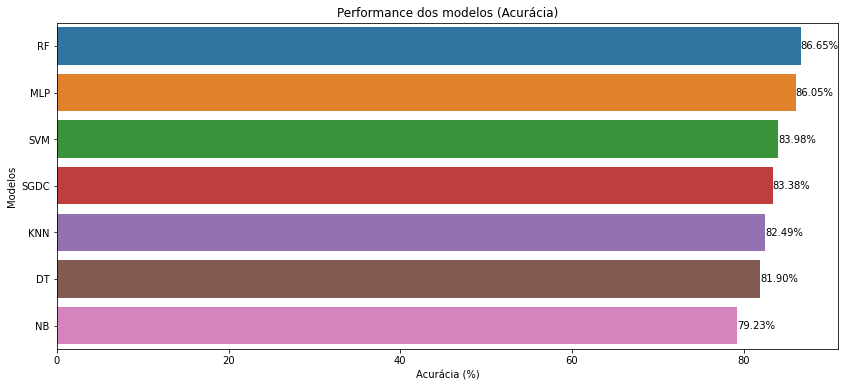

In [ ]:
#!pip install matplotlib==3.4.0
#!pip show matplotlib
fig, ax = plt.subplots(figsize=(14,6))
#plt.figure()
ax = sns.barplot(x='ACC', y="Modelos", data=histograma.sort_values(by='ACC', ascending=False))
#ax.bar_label(ax.containers[0])
plt.title("Performance dos modelos (Acurácia)")
plt.xlabel("Acurácia (%)")
plt.ylabel("Modelos")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')
plt.show();

VP = Verdadeiro positivo - objeto pertence a classe A e foi classificado na classe A

VN = Verdadeiro negativo - objeto não pertence a classe A e não foi classificado na classe A

FP = Falso positivo - objeto não pertence a classe A e foi classificado na classe A

FN = Falso negativo - objeto pertence a classe A e não foi classificado na classe A

A sensibilidade/revocação/recall do classificador, por classe,  pode ser medida pela chamada da função seguinte:

In [ ]:
modelo = ["KNN", "MLP", "SGDC", "svm", "decision_tree", "naive_bayes", "random_forest"]

def precision(y_test, results):
    return metrics.precision_score(y_test, results, average=None)
def recall(y_test, results):
    return metrics.recall_score(y_test, results, average=None)
def f1_score(y_test, results):
    return metrics.f1_score(y_test, results, average=None)

def printScore(modelo, avali):
    for i in range(0, len(modelo)):
        print("precision {}: {}".format(modelo[i], np.around(avali(y_test, results[i]),3)))

print("Precision")
printScore(modelo, precision)
print("recall")
printScore(modelo, recall)
print("f1_score")
printScore(modelo, f1_score)


Precision
precision KNN: [0.778 0.707 0.804 0.959]
precision MLP: [0.817 0.783 0.861 0.943]
precision SGDC: [0.784 0.717 0.831 0.95 ]
precision svm: [0.793 0.75  0.817 0.95 ]
precision decision_tree: [0.847 0.652 0.775 0.942]
precision naive_bayes: [0.669 0.816 0.846 0.897]
precision random_forest: [0.848 0.882 0.805 0.925]
recall
precision KNN: [0.7   0.683 0.949 0.939]
precision MLP: [0.76  0.783 0.872 1.   ]
precision SGDC: [0.69  0.717 0.949 0.96 ]
precision svm: [0.69  0.7   0.974 0.97 ]
precision decision_tree: [0.72  0.75  0.795 0.98 ]
precision naive_bayes: [0.85  0.517 0.705 0.97 ]
precision random_forest: [0.78  0.75  0.897 1.   ]
f1_score
precision KNN: [0.737 0.695 0.871 0.949]
precision MLP: [0.788 0.783 0.866 0.971]
precision SGDC: [0.734 0.717 0.886 0.955]
precision svm: [0.738 0.724 0.889 0.96 ]
precision decision_tree: [0.778 0.698 0.785 0.96 ]
precision naive_bayes: [0.749 0.633 0.769 0.932]
precision random_forest: [0.812 0.811 0.848 0.961]


In [ ]:
modelo = ["KNN", "MLP", "SGDC", "svm", "decision_tree", "naive_bayes", "random_forest"]

def precision(y_test, results):
    return metrics.precision_score(y_test, results, average=None)
def recall(y_test, results):
    return metrics.recall_score(y_test, results, average=None)
def f1_score(y_test, results):
    return metrics.f1_score(y_test, results, average=None)

def printScore(modelo, avali):
    for i in range(0, len(modelo)):
        print("precision {}: {}".format(modelo[i], avali(y_test, results[i])))

print("Precision")
printScore(modelo, precision)
print("recall")
printScore(modelo, recall)
print("f1_score")
printScore(modelo, f1_score)


Precision
precision KNN: [0.77777778 0.70689655 0.80434783 0.95876289]
precision MLP: [0.8172043  0.78333333 0.86075949 0.94285714]
precision SGDC: [0.78409091 0.71666667 0.83146067 0.95      ]
precision svm: [0.79310345 0.75       0.8172043  0.95049505]
precision decision_tree: [0.84705882 0.65217391 0.775      0.94174757]
precision naive_bayes: [0.66929134 0.81578947 0.84615385 0.89719626]
precision random_forest: [0.84782609 0.88235294 0.8045977  0.92523364]
recall
precision KNN: [0.7        0.68333333 0.94871795 0.93939394]
precision MLP: [0.76       0.78333333 0.87179487 1.        ]
precision SGDC: [0.69       0.71666667 0.94871795 0.95959596]
precision svm: [0.69       0.7        0.97435897 0.96969697]
precision decision_tree: [0.72       0.75       0.79487179 0.97979798]
precision naive_bayes: [0.85       0.51666667 0.70512821 0.96969697]
precision random_forest: [0.78      0.75      0.8974359 1.       ]
f1_score
precision KNN: [0.73684211 0.69491525 0.87058824 0.94897959]
preci

In [ ]:
#!pip install matplotlib==3.4.0
#!pip show matplotlib
fig, ax = plt.subplots(figsize=(14,6))
#plt.figure()
ax = sns.barplot(x='ACC', y="Modelos", data=histograma.sort_values(by='ACC', ascending=False))
#ax.bar_label(ax.containers[0])
plt.title("Performance dos modelos")
plt.xlabel("Acurácia (%)")
plt.ylabel("Modelos")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')
plt.show();

### Matriz de confusão

In [ ]:
def get_confusion_matrix(y_true, y_pred, modelo):
    labels = ['cloudy','rain','shine','sunrise']
    cm = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues').set(title=modelo, ylabel='True Label', xlabel='Predicted Label')

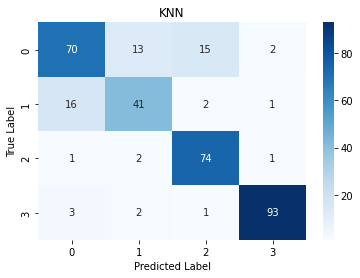

In [ ]:
get_confusion_matrix(y_test, results[0], modelo[0])

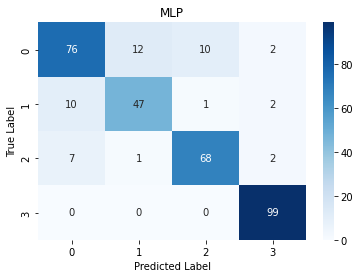

In [ ]:
get_confusion_matrix(y_test, results[1], modelo[1])

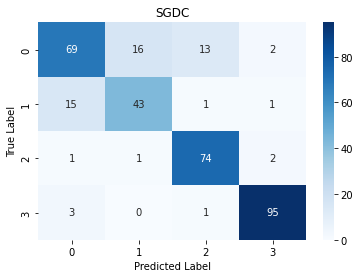

In [ ]:
get_confusion_matrix(y_test, results[2], modelo[2])

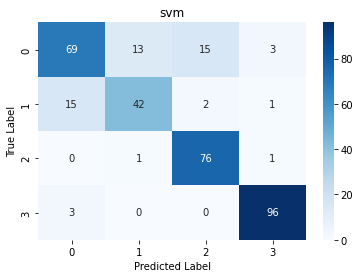

In [ ]:
get_confusion_matrix(y_test, results[3], modelo[3])

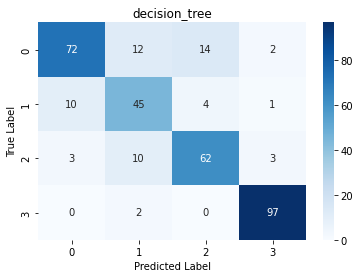

In [ ]:
get_confusion_matrix(y_test, results[4], modelo[4])

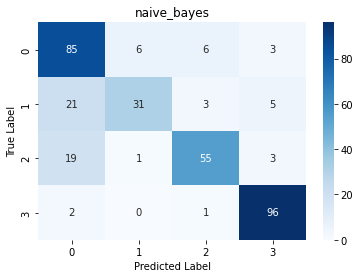

In [ ]:
get_confusion_matrix(y_test, results[5], modelo[5])

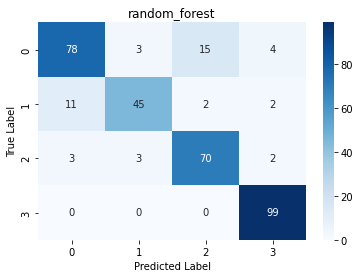

In [ ]:
get_confusion_matrix(y_test, results[6], modelo[6])

### Tunning de hiper-parametros

In [ ]:
model = {}
model[0] = svm.SVC(kernel='linear')
model[1] = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)
model[2] = GaussianNB()
model[3] = tree.DecisionTreeClassifier()
model[4] = RandomForestClassifier(criterion= 'entropy', max_depth= 8, max_features='auto', n_estimators=200)
model[5] = MLPClassifier(max_iter=300, activation = 'relu', solver='adam', random_state=1)
model[6] = KNeighborsClassifier()

cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.00]
param_penalty = ['l1', 'l2', 'elasticnet']
param_solver = ['lbfgs', 'sgd', 'adam']
n_estimators = [50, 100, 200]
max_depth = [3, 5, 7]
max_iter = [100, 1000, 10000]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
max_features = ['auto', 'sqrt', 'log2']
criterion = ['gini', 'entropy', 'log_loss']
weights = [ 'uniform', 'distance'] 
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
p = [1, 2]
activation = ['identity', 'logistic', 'tanh', 'relu']

params = {}
params[0] = [{'kernel': kernel, 'C': param_range, 'random_state': [42], 'gamma': param_range }]
params[1] = [{'eta0': param_range, 'max_iter': max_iter, 'penalty': param_penalty, 'random_state': [42], 'alpha': param_range }]
params[2] = [{}]
params[3] = [{'criterion': criterion, 'max_depth': max_depth, 'random_state': [42], 'min_impurity_decrease': param_range}]
params[4] = [{'max_features': max_features ,'criterion': criterion, 'n_estimators': n_estimators , 'max_depth': max_depth ,'random_state': [42]}]
params[5] = [{'alpha': param_range, 'activation': activation, 'solver': param_solver, 'random_state': [42]}]
params[6] = [{'p': p, 'n_neighbors': max_depth, 'weights': weights, 'algorithm': algorithm}]

gs = {}
acc = {}
for i in model.keys():
    print(i)
    gs[i] = GridSearchCV(estimator=model[i], param_grid=params[i], cv=cv)
    gs[i].fit(X_train, y_train)

0
1
2
3


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
54 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_mes

4


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

5


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

6


In [ ]:
model_name = ['SVC', 'SGD', 'GaussianNB', 'DecisionTree', 'RF', 'MLP', 'KNN']

In [ ]:
for i in gs.keys():
    print(model_name[i])
    print("Melhores parametros: ", gs[i].best_estimator_)
    print("Acc treino: ", gs[i].best_score_)
    print("Acc teste: ",gs[i].best_estimator_.score(X_test, y_test))

SVC
Melhores parametros:  SVC(C=10.0, gamma=1.0, random_state=42)
Acc treino:  0.8638676844783716
Acc teste:  0.8724035608308606
SGD
Melhores parametros:  SGDClassifier(eta0=0.0001, max_iter=100, penalty='l1', random_state=42)
Acc treino:  0.8409669211195929
Acc teste:  0.8367952522255193
GaussianNB
Melhores parametros:  GaussianNB()
Acc treino:  0.7684478371501272
Acc teste:  0.7922848664688428
DecisionTree
Melhores parametros:  DecisionTreeClassifier(criterion='entropy', max_depth=7,
                       min_impurity_decrease=0.01, random_state=42)
Acc treino:  0.762086513994911
Acc teste:  0.7952522255192879
RF
Melhores parametros:  RandomForestClassifier(max_depth=7, n_estimators=200, random_state=42)
Acc treino:  0.8549618320610687
Acc teste:  0.8694362017804155
MLP
Melhores parametros:  MLPClassifier(alpha=0.1, max_iter=300, random_state=42, solver='lbfgs')
Acc treino:  0.8600508905852418
Acc teste:  0.8427299703264095
KNN
Melhores parametros:  KNeighborsClassifier(p=1, weights